In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from torch.utils.data import Dataset
import torch

file_path = '/home/diego/Projects/Timeseries currency with transformers/data/raw/exchange_rate.txt'
df = pd.read_csv(file_path, delimiter=',') 
df.columns = ['Australia', 'British', 'Canada', 'Switzerland', 'China', 'Japan', 'New Zealand', 'Singapore']

exchange_country = ['Australia', 'British', 'Canada', 'Switzerland', 
                    'China', 'Japan','New Zealand', 'Singapore']

In [25]:
class ExchangeRateDataset(Dataset):
    def __init__(self, data, input_len, output_len):
        """
        Dataset for time series with support for multivariate data.
        """
        # Convert to NumPy if needed
        if isinstance(data, pd.DataFrame):
            data = data.values
        self.data = data
        self.input_len = input_len
        self.output_len = output_len

    def __len__(self):
        """
        Calculates the number of available windows in the data.
        """
        return len(self.data) - (self.input_len + self.output_len) + 1

    def __getitem__(self, idx):
        """
        Retrieves a pair of input and output sequences for a given index.
        """
        if not isinstance(idx, int):
            idx = idx[0]  # Extract integer if it's a list or slice

        idx_end = idx + self.input_len
        input_seq = self.data[idx:idx_end, :]  # Window for inputs
        output_seq = self.data[idx_end:idx_end + self.output_len, :]  # Window for outputs
        # Convert to tensors
        input_seq = torch.tensor(input_seq, dtype=torch.float32)
        output_seq = torch.tensor(output_seq, dtype=torch.float32)
        return input_seq, output_seq

def __getitem__(self, idx):
    print(f"Index received: {idx}")
    # Original code follows...

dataset = ExchangeRateDataset(df, input_len=18, output_len=1)
print(dataset[0])  # Should return the first input-output pair




(tensor([[0.7818, 1.6100, 0.8611, 0.6335, 0.2112, 0.0069, 0.5940, 0.5240],
        [0.7867, 1.6293, 0.8610, 0.6485, 0.2112, 0.0070, 0.5973, 0.5263],
        [0.7860, 1.6370, 0.8621, 0.6506, 0.2112, 0.0070, 0.5970, 0.5238],
        [0.7849, 1.6530, 0.8620, 0.6563, 0.2112, 0.0069, 0.5985, 0.5274],
        [0.7866, 1.6537, 0.8610, 0.6549, 0.2112, 0.0069, 0.6040, 0.5262],
        [0.7886, 1.6620, 0.8629, 0.6612, 0.2112, 0.0069, 0.6070, 0.5276],
        [0.7910, 1.6568, 0.8643, 0.6596, 0.2112, 0.0069, 0.6084, 0.5276],
        [0.7939, 1.6695, 0.8642, 0.6691, 0.2112, 0.0069, 0.6115, 0.5281],
        [0.7894, 1.6570, 0.8584, 0.6594, 0.2112, 0.0069, 0.6090, 0.5281],
        [0.7917, 1.6495, 0.8591, 0.6637, 0.2112, 0.0069, 0.6120, 0.5294],
        [0.7941, 1.6445, 0.8538, 0.6585, 0.2112, 0.0068, 0.6140, 0.5291],
        [0.7935, 1.6465, 0.8482, 0.6603, 0.2112, 0.0069, 0.6106, 0.5328],
        [0.7954, 1.6390, 0.8453, 0.6527, 0.2112, 0.0068, 0.6118, 0.5321],
        [0.7751, 1.6490, 0.8489, 0.66

In [26]:
# Split dataset into train, validation, and out-of-sample
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
test_size = len(df) - train_size - val_size

train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
oos_data = df[train_size + val_size:]

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Out-of-Sample size: {len(oos_data)}")

Train size: 5310
Validation size: 1517
Out-of-Sample size: 760


In [21]:
# Create datasets with 18 months input and 1 month output
input_len = 18  # 18 months input
output_len = 1  # 1 month output

train_dataset = ExchangeRateDataset(train_data, input_len, output_len)
val_dataset = ExchangeRateDataset(val_data, input_len, output_len)
oos_dataset = ExchangeRateDataset(oos_data, input_len, output_len)

# Check dataset sizes
len(train_dataset), len(val_dataset), len(oos_dataset)


(5292, 1499, 742)

In [31]:
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_dim):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)  # Linear embedding for input
        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=512,
            dropout=0.1,
            batch_first=True  # Ensure batch is the first dimension
        )
        self.fc_out = nn.Linear(embed_dim, output_dim)  # Output layer

    def forward(self, src, tgt):
        # Embed inputs
        src = self.embedding(src)
        tgt = self.embedding(tgt)
        # Pass through Transformer
        output = self.transformer(src, tgt)
        # Final output layer
        return self.fc_out(output)



In [33]:
from torch.utils.data import DataLoader
import torch.nn as nn
# DataLoaders with batch size 64
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop setup
import torch.optim as optim

# Initialize model
model = TimeSeriesTransformer(input_dim=8, embed_dim=64, num_heads=4, num_layers=3, output_dim=8)
criterion = nn.MSELoss()  # Loss function for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100  # Number of epochs
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs, targets)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs, targets)
            val_loss += criterion(outputs, targets).item()

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}")


Epoch 1/100, Train Loss: 0.0447, Validation Loss: 0.0328
Epoch 2/100, Train Loss: 0.0137, Validation Loss: 0.0205
Epoch 3/100, Train Loss: 0.0060, Validation Loss: 0.0042
Epoch 4/100, Train Loss: 0.0037, Validation Loss: 0.0023
Epoch 5/100, Train Loss: 0.0027, Validation Loss: 0.0024
Epoch 6/100, Train Loss: 0.0022, Validation Loss: 0.0022
Epoch 7/100, Train Loss: 0.0018, Validation Loss: 0.0023
Epoch 8/100, Train Loss: 0.0016, Validation Loss: 0.0016
Epoch 9/100, Train Loss: 0.0014, Validation Loss: 0.0016
Epoch 10/100, Train Loss: 0.0013, Validation Loss: 0.0028
Epoch 11/100, Train Loss: 0.0011, Validation Loss: 0.0020
Epoch 12/100, Train Loss: 0.0010, Validation Loss: 0.0031
Epoch 13/100, Train Loss: 0.0009, Validation Loss: 0.0027
Epoch 14/100, Train Loss: 0.0009, Validation Loss: 0.0027
Epoch 15/100, Train Loss: 0.0009, Validation Loss: 0.0027
Epoch 16/100, Train Loss: 0.0008, Validation Loss: 0.0033
Epoch 17/100, Train Loss: 0.0008, Validation Loss: 0.0022
Epoch 18/100, Train Los

In [34]:
# Create the DataLoader for the OOS dataset
oos_loader = DataLoader(oos_dataset, batch_size=64, shuffle=False)

# Evaluate the model on OOS
model.eval()
oos_loss = 0.0
with torch.no_grad():
    for inputs, targets in oos_loader:
        outputs = model(inputs, targets)
        oos_loss += criterion(outputs, targets).item()

print(f"Out-of-Sample Loss: {oos_loss / len(oos_loader):.4f}")



Out-of-Sample Loss: 0.0026


In [41]:
# Evaluate on OOS
model.eval()
real = []
predicted = []

with torch.no_grad():
    for inputs, targets in oos_loader:
        outputs = model(inputs, targets)
        real.append(targets.numpy())
        predicted.append(outputs.numpy())

# Flatten arrays
real = np.concatenate(real, axis=0)  # Shape: [samples, features]
predicted = np.concatenate(predicted, axis=0)  # Shape: [samples, features]

# Validate shapes
print(f"Real shape: {real.shape}")
print(f"Predicted shape: {predicted.shape}")


Real shape: (742, 1, 8)
Predicted shape: (742, 1, 8)


In [43]:
print(f"Real shape: {real.shape}")
print(f"Predicted shape: {predicted.shape}")


Real shape: (742, 1, 8)
Predicted shape: (742, 1, 8)


Real shape after squeeze: (742, 8)
Predicted shape after squeeze: (742, 8)


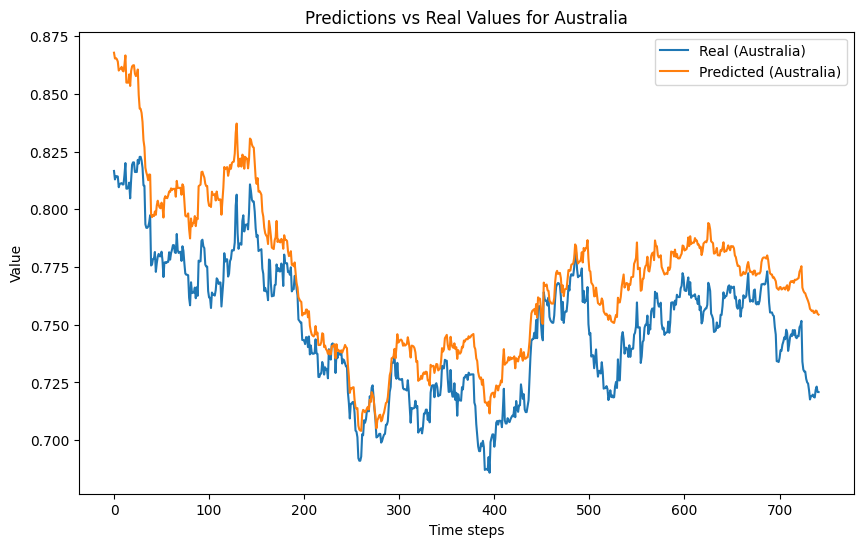

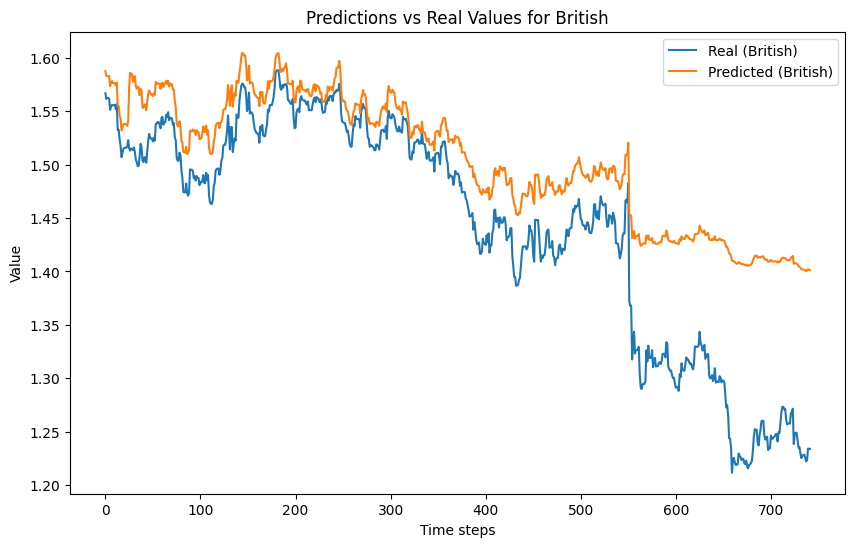

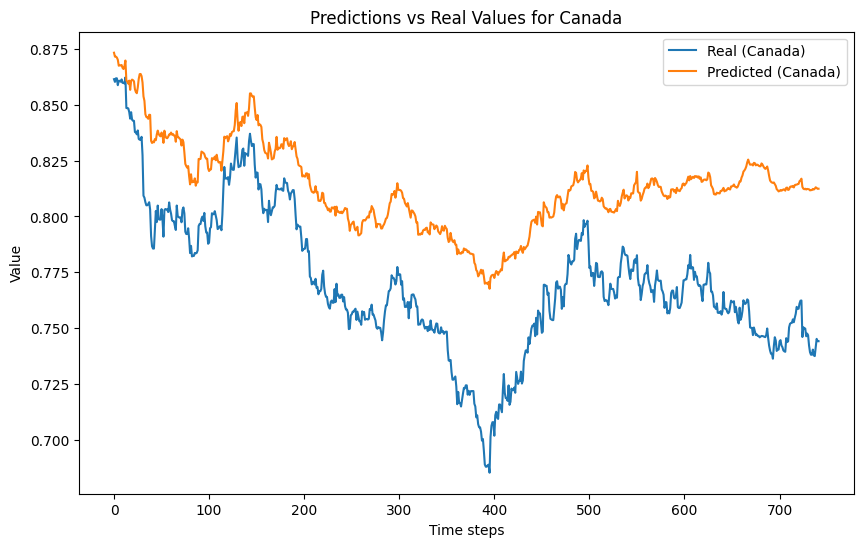

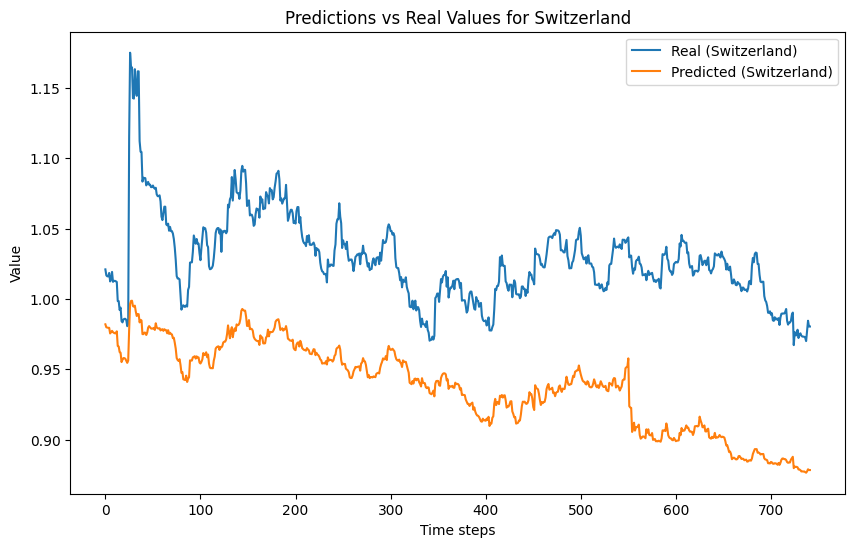

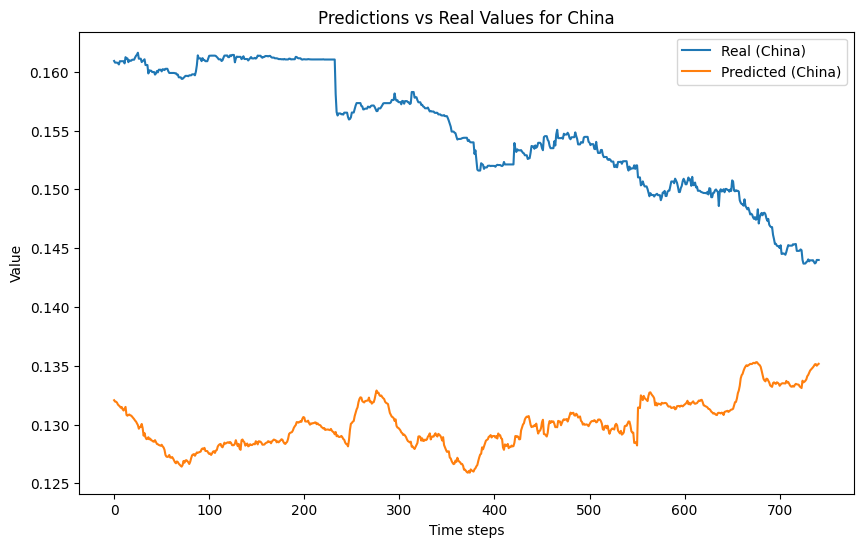

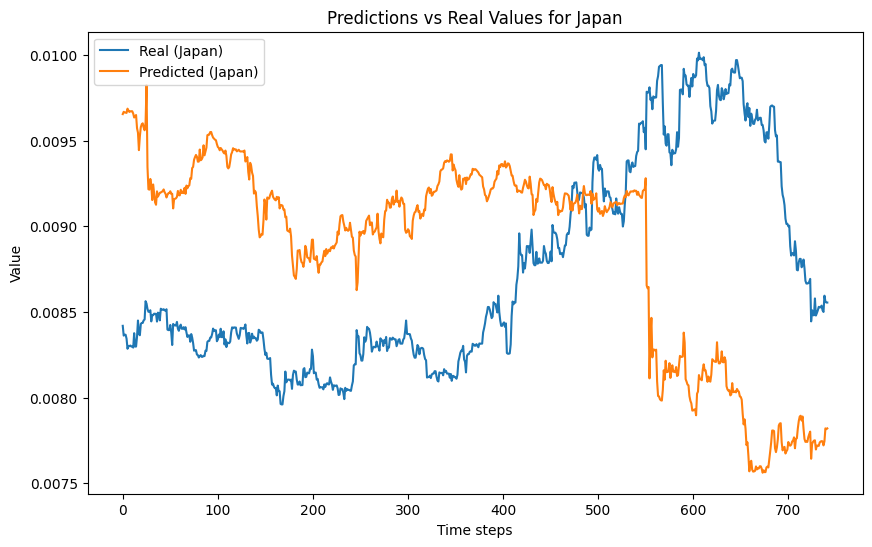

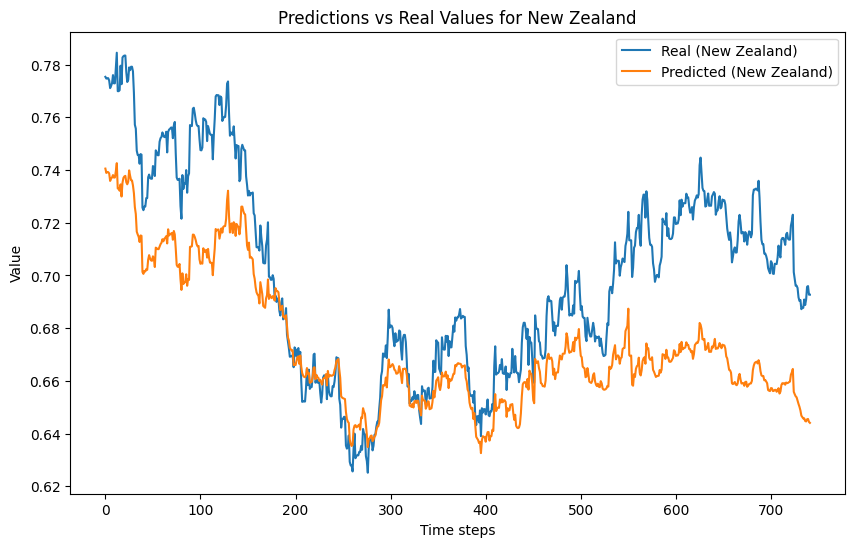

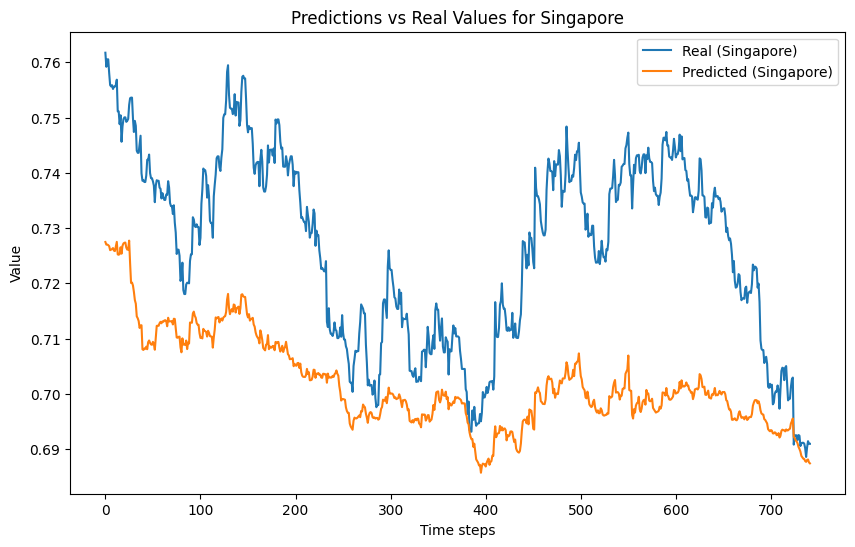

In [44]:
# Remove the extra sequence dimension (dim=1)
real = real.squeeze(1)  # Shape: (742, 8)
predicted = predicted.squeeze(1)  # Shape: (742, 8)

# Validate shapes again
print(f"Real shape after squeeze: {real.shape}")
print(f"Predicted shape after squeeze: {predicted.shape}")

# Ensure the number of names matches the number of features
assert len(exchange_country) == real.shape[1], "Mismatch between currency names and features."

# Plot each currency separately
for i in range(len(exchange_country)):
    plt.figure(figsize=(10, 6))
    plt.plot(real[:, i], label=f"Real ({exchange_country[i]})")
    plt.plot(predicted[:, i], label=f"Predicted ({exchange_country[i]})")
    plt.legend()
    plt.title(f"Predictions vs Real Values for {exchange_country[i]}")
    plt.xlabel("Time steps")
    plt.ylabel("Value")
    plt.show()


In [45]:
mae_per_currency = np.mean(np.abs(real - predicted), axis=0)
for i, currency in enumerate(exchange_country):
    print(f"{currency}: MAE = {mae_per_currency[i]:.4f}")


Australia: MAE = 0.0208
British: MAE = 0.0613
Canada: MAE = 0.0427
Switzerland: MAE = 0.0900
China: MAE = 0.0249
Japan: MAE = 0.0009
New Zealand: MAE = 0.0276
Singapore: MAE = 0.0246
